# Mean-Reversion

Hedge funds generate returns by taking on risks, which can be categorized into idiosyncratic risk and aggregate risk. Idiosyncratic risk is specific to individual assets or sectors and can be mitigated through diversification. Aggregate risk, affecting the broader market, cannot be diversified away and requires hedging strategies. The returns earned by hedge funds are the reward for navigating and exploiting these risks effectively.

In this section, we discuss one particular risk-taking stategy on stocks --  `liquidity provision` (or `mean-reversion`) -- and discuss its performance during the period elevated aggregated risk in August 2007. 

Hedge funds need to consider two key factors in their overall approach to risk-taking:

- Risk management: Effective risk management often relies on improved risk models. We will examine the use of risk-model shrinkage as a method to decrease the over-realization of risk. 

- Leverage management: another aspect of risk is the management of leverage and we discuss how to reduce the risk-per-unit of leverage by concentrating the positions or the predictors. 

## Liquidity and autocorrelation of stock returns

In [1]:
# hide
from IPython.display import Image, display

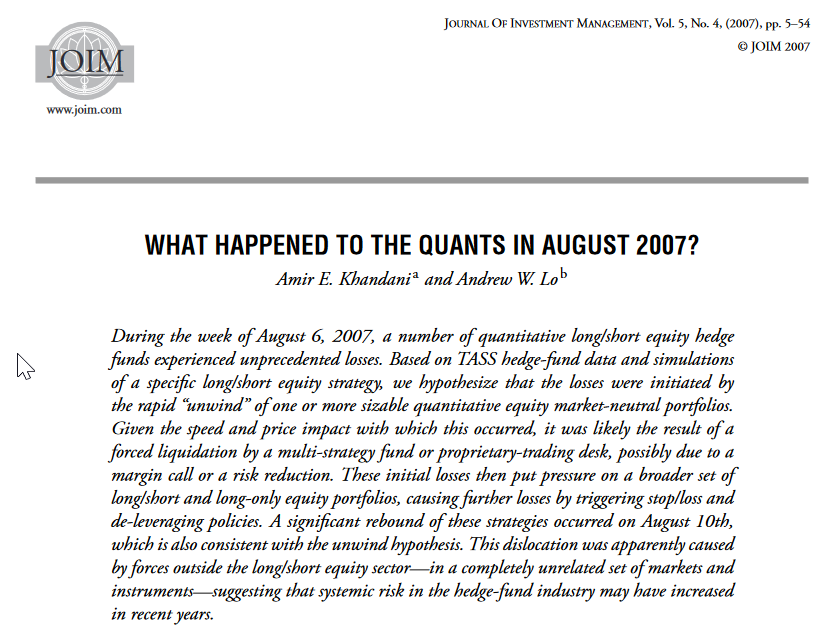

In [2]:
# hide
display(Image("images/khandani_1.png", width=500))

Hedge funds as provider of liquidity is trend perfected by Long-Term Capital Management (until its
fatal crash in 1998...): 

> "by taking long positions in stocks that have declined and short positions in stocks that have advanced over the previous
day, the strategy actively provides liquidity to the marketplace;"

This type of strategies generally requires a very high leverage, so anticipating market dislocations is key. Khandani-Lo (2007) argue that hedge funds have overtook traditional market makers as liquidity providers, so much so that when hedge funds retract, the whole market collapses...

Mean-reversion is a contrarian strategy where the holdings positive in past losers and negative in past winners: 
    
$$h_{n, t} = - 1 \times \frac{1}{N} \left(r_{n, t} - r_{\text{Market}, t} \right), $$

where $r_{\text{Market}, t} = \frac{1}{N} \sum_n r_{n, t}$ is the cross-sectional average. By construction, such a strategy is cash-neutral: 

$$ \sum_n h_{n, t} = 0.$$ 

Khandani and Lo (2007) show that a market-making liquidity provision exhibited extreme losses during the week of August 6, 2007 suggesting market-wide deleveraging.

> "We wish to acknowledge at the outset that the hypotheses advanced in this paper are speculative, tentative, and based solely on indirect evidence."

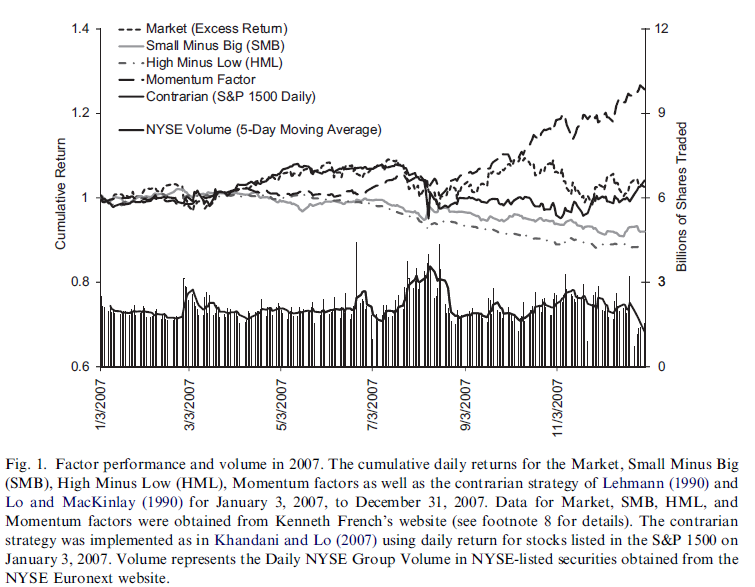

In [3]:
# hide
display(Image("images/khandaniLoFigure1.PNG", width=500))

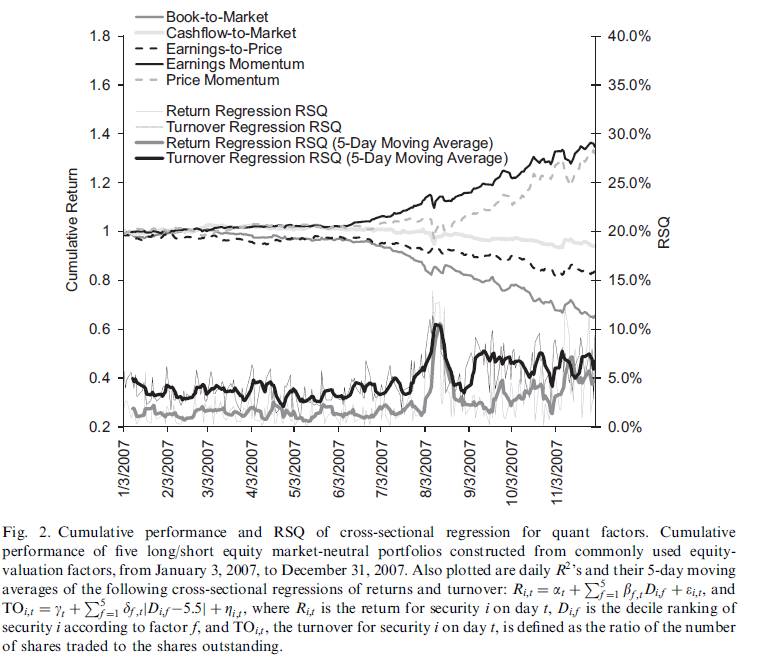

In [4]:
# hide
display(Image("images/khandaniLoFigure2.PNG", width=500))

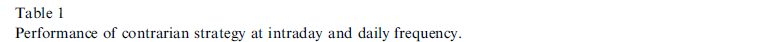

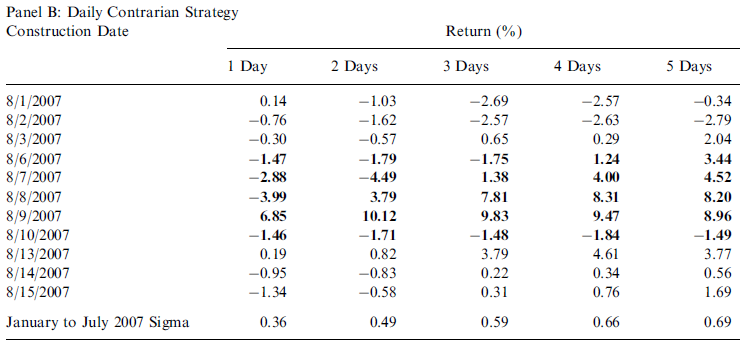

In [5]:
# hide
display(Image("images/khandaniLoTable1Header.PNG", width=500))
display(Image("images/khandaniLoTable1.PNG", width=500))

Quantitative equity fnds were hit in August 2007 especifically on August 7th–9th with massive reversal on August 10th. Some of the most consistently profitable funds lost too. Moreover, it seemed to only affect quants and it was not related to any real market news. 

Kandhani-Lo “Unwind hypothesis:"

- many quant funds use similar factor models
- if one fund has to unwind a large position, that hurts other funds
- this causes these other funds to sell as well...

Sequence of event:

-  initial losses "initiated by the rapid unwind of one or more sizeable quantitative equity market-neutral portfolios (likely the result of a force liquidation by a multi-strategy fund or proprietary desk, possibly due to a margin call or a risk reduction)"
- "these initial losses put pressure on a broader set of long/short and long-only equity portfolios, causing further losses by triggering stop/loss and deleveraging policies"
- "on Friday, August 10th, sharp reversals in all five strategies erased nearly all of the losses of the previous four days, returning portfolio values back to their levels on the morning of August 6th. Of course, this assumes that portfolio leverage did not change during this tumultuous week, which is an unlikely assumption given the enormous losses during the first few days."

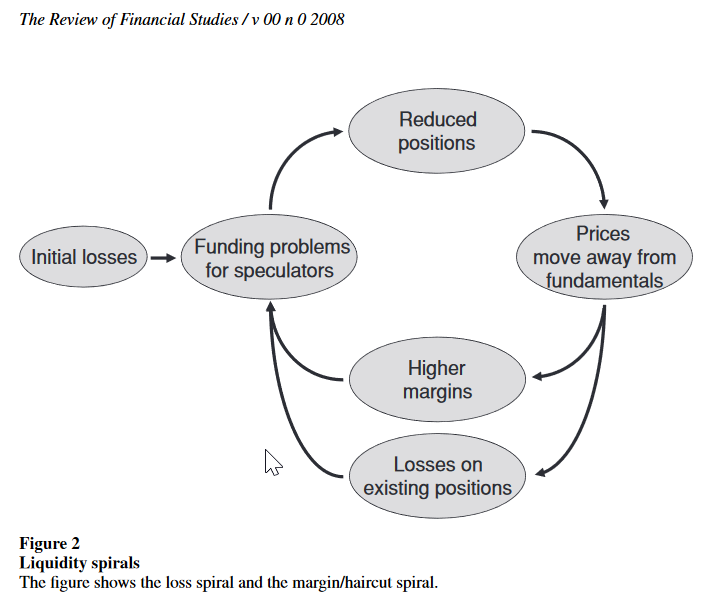

In [6]:
# hide
display(Image("images/brunnermeier_1.png", width=500))

## Sample 

In [7]:
# hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
from IPython.display import Image
from matplotlib import pyplot as plt
from skfin.metrics import sharpe_ratio
from skfin.plot import bar, line
from tqdm.auto import tqdm

In [8]:
from skfin.datasets_ import load_sklearn_stock_returns

ret = load_sklearn_stock_returns(cache_dir="data")

INFO:skfin.dataloaders.cache:Loading from cache : data/sklearn_returns.parquet


This stock return is found in the `example` folder on `scikit-learn` github repository and contains returns from 2003 to 2008. Interestingly, it includes not only US companies, but also European (e.g. Total, SAP, Novartis, etc) and Japanese (Honda, Sony, Toyota) ones. Moreover, some companies are no longer publically traded (e.g. Dell) or have been split (DuPont). 

In particular, removing firms that are no longer publicly traded would create a survival bias in the sample. More generally, it is important to make sure that the firms that would have been available for trading are dynamically included in the backtest sample and removed when there are no longer traded (or not liquid enough to be traded given transaction costs). 

## Mean-reversion strategy

We load the same functions as the ones we used for the industry backtest.

In [9]:
from skfin.backtesting import Backtester
from skfin.mv_estimators import MeanVariance

Rather than setting the positions as $-1 \times$ returns (as Khandani and Lo do), we feed the $-1 \times$ EMA(returns) into the `Backtester` class to get mean-variance positions. 

In [10]:
def xs_score(x, clip=5):
    return (
        x.sub(x.mean(axis=1), axis=0)
        .div(x.std(axis=1), axis=0)
        .clip(lower=-clip, upper=clip)
    )

In [11]:
transform_X = lambda x: -1 * x.pipe(xs_score).ewm(halflife=5).mean().fillna(0)
transform_y = lambda x: x.shift(-1).fillna(0)
features = transform_X(ret)
target = transform_y(ret)

In contrast to the industry backtests (which were at the Monthly frequency), these mean-reversion backtests are at the (business) day frequency.

In [12]:
ret.equals(ret.resample("B").mean())

True

The backtest is setup so that the risk-model is computed over 3-months (=63 business days).

In [13]:
risk_model_window = 63

In [14]:
m = (
    Backtester(
        MeanVariance(), max_train_size=risk_model_window, start_date="2003-05-01"
    )
    .compute_holdings(features, target)
    .compute_pnl(ret)
)

hs = {"no-shrinkage": m.h_}

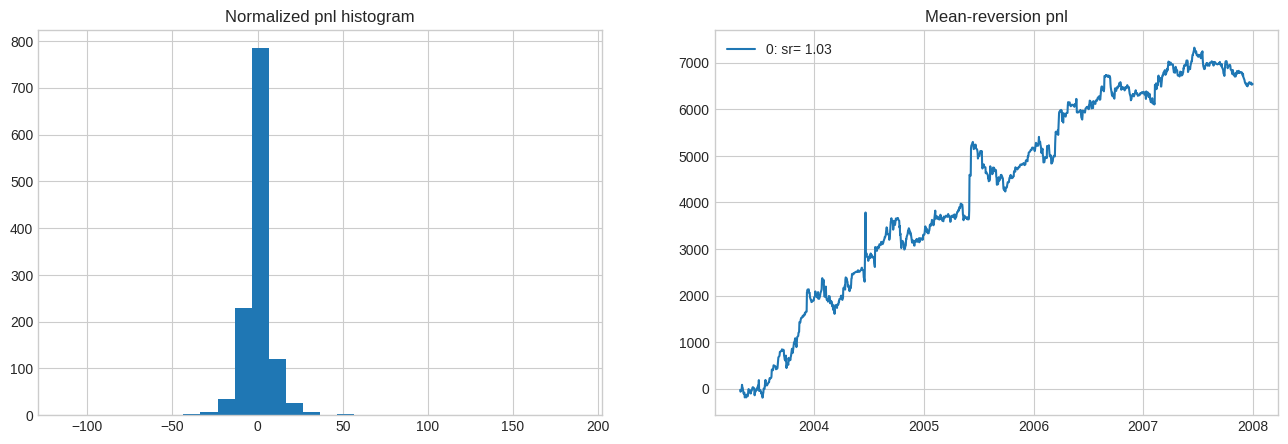

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
m.pnl_.div(np.sqrt(risk_model_window)).hist(bins=30, ax=ax[0])
ax[0].set_title("Normalized pnl histogram")
line(
    m.pnl_,
    cumsum=True,
    start_date="2003-05-01",
    title="Mean-reversion pnl",
    ax=ax[1],
    loc="best",
)

The graph below shows the lead-lag sharpe ratio. The right graph shows the lag: the $0$ lag is the tradable lag with a sharpe ratio equal to 1.06 (as in the cumulative pnl graph above). Lagging trading by several business days (up to five) maintain sharpe ratio approximately constant. 

The left graph shows the "lead" sharpe ratios -- that is, the counterfactual of what the sharpe ratio would have been with future information. Given that the strategy is strong countrarian, this lead sharpe ratio is very negative. 

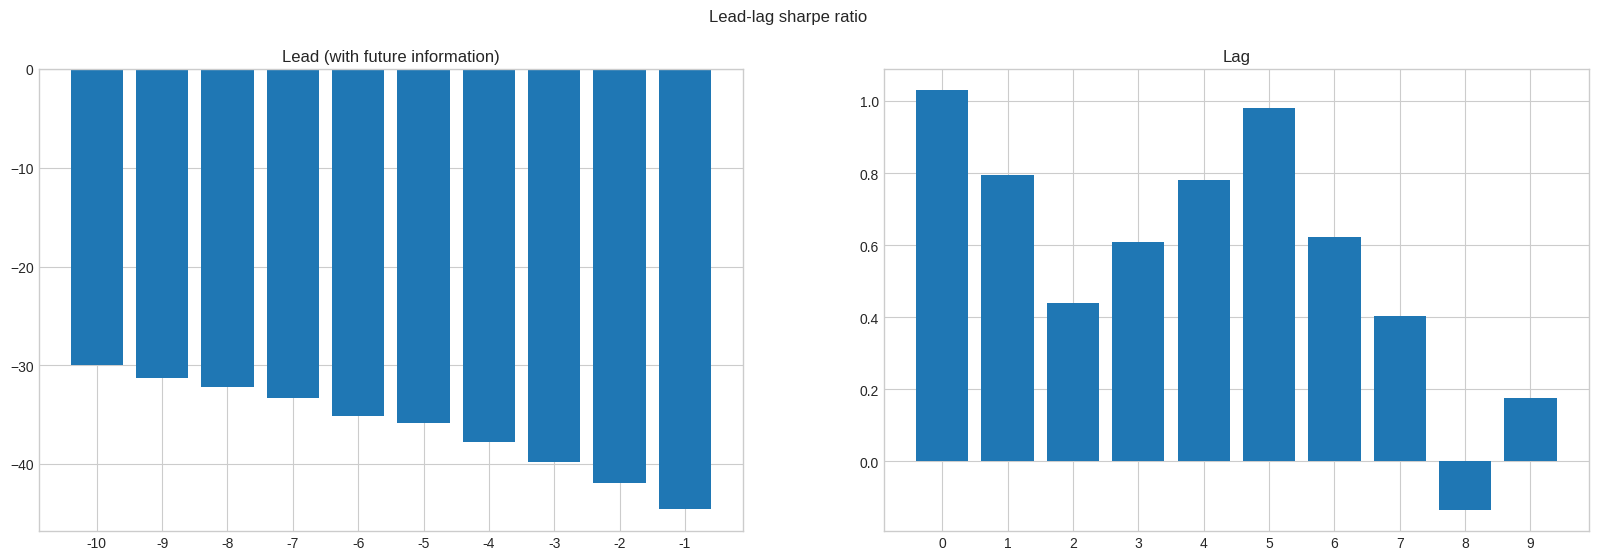

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
fig.suptitle("Lead-lag sharpe ratio")
bar(
    {
        i: m.h_.shift(1 + i).mul(ret).sum(axis=1).pipe(sharpe_ratio)
        for i in range(-10, 0)
    },
    sort=False,
    title="Lead (with future information)",
    ax=ax[0],
)

bar(
    {
        i: m.h_.shift(1 + i).mul(ret).sum(axis=1).pipe(sharpe_ratio)
        for i in range(0, 10)
    },
    sort=False,
    title="Lag",
    ax=ax[1],
)

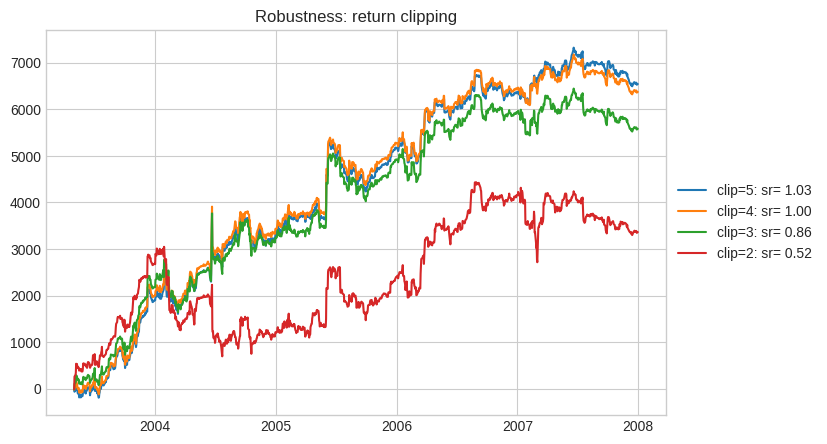

In [17]:
m_ = Backtester(
    MeanVariance(), max_train_size=risk_model_window, start_date="2003-05-01"
)
pnls_ = {}
for clip in [2, 3, 4, 5]:
    transform_X_ = lambda x: -1 * x.pipe(xs_score, clip=clip).ewm(
        halflife=5
    ).mean().fillna(0)
    features_ = transform_X_(ret)
    pnls_[f"clip={clip}"] = m_.train(features_, target, ret)
line(pnls_, cumsum=True, title="Robustness: return clipping")

## Mean-reversion with risk-model shrinkage

Intuitively, risk-model shrinkage is more necessary and useful with more assets (e.g. many stocks versus few industries). We show how the shrinkage of the coveriance matrix helps reducing the over-realisation of risk. 

In [18]:
from sklearn.covariance import ShrunkCovariance

pnls_ = {}
for shrinkage in [0, 0.001, 0.01, 0.1]:
    transform_V_ = lambda x: ShrunkCovariance(shrinkage=shrinkage).fit(x).covariance_
    pnls_[shrinkage] = Backtester(
        MeanVariance(transform_V=transform_V_),
        max_train_size=risk_model_window,
        start_date="2003-05-01",
    ).train(features, target, ret)

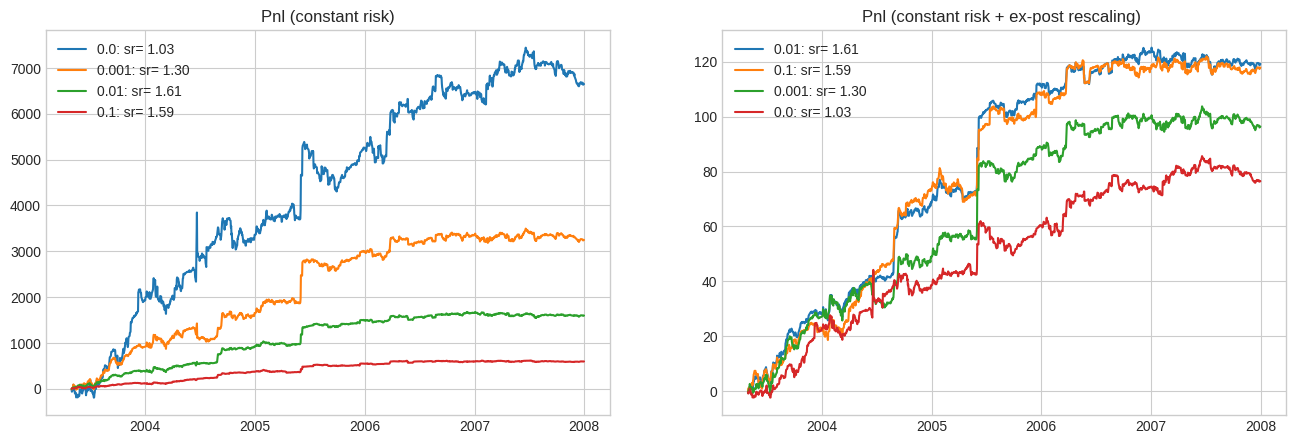

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

line(pnls_, cumsum=True, title="Pnl (constant risk)", loc="best", ax=ax[0])
line(
    pd.concat(pnls_, axis=1).pipe(lambda x: x.div(x.std())),
    cumsum=True,
    title="Pnl (constant risk + ex-post rescaling) ",
    loc="best",
    ax=ax[1],
)

We see that with no risk-model shrinkage, the over-realisation of risk is very significant. With some shrinkage, there are less pnl outliers -- as shown in the histogram below. 

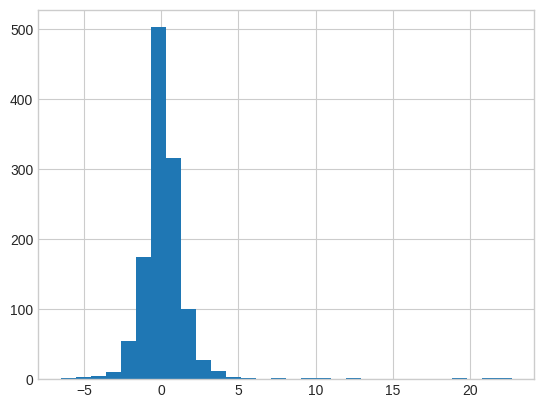

In [20]:
pnls_[0.01].div(np.sqrt(risk_model_window)).hist(bins=30);

## Leverage of mean-reversion strategies

Concentrating portfolio positions—in other words, setting smaller positions close to zero—can help increase the risk per unit of leverage. Intuitively, when a portfolio is very diversified across many positions, the realized risk is low -- which is great to generate a high Sharpe ratio, but not necessarily good to generate high returns. 

In this section, we discuss how we can increase the level of risk per unit of leverage by concentrating the positions. 

$$
risk\_per\_unit\_of\_leverage = STD\left[\frac{h_t^T r_t}{||h_t||_1}\right]
$$

As the ratio of a L2 and L1 norms, the risk-per-unit-of-leverage is related to other concentration measures such as the Herfindahl-Hirschman Index or the Gini coefficient. 

In [21]:
from skfin.metrics import sharpe_ratio

leverage_scaling = lambda x: x.div(x.abs().sum(axis=1), axis=0)


def risk_per_unit_of_leverage(h, ret, return_sharpe_ratio=False):
    pnl = h.pipe(leverage_scaling).shift(1).mul(ret).sum(axis=1).loc[h.index]
    if return_sharpe_ratio:
        return {"std": pnl.std() * np.sqrt(252), "sharpe_ratio": pnl.pipe(sharpe_ratio)}
    else:
        return pnl.std() * np.sqrt(252)

In [22]:
shrinkage = 0.01
transform_V_ = lambda x: ShrunkCovariance(shrinkage=shrinkage).fit(x).covariance_
m_ = (
    Backtester(
        MeanVariance(transform_V=transform_V_),
        max_train_size=risk_model_window,
        start_date="2003-05-01",
    )
    .compute_holdings(features, target)
    .compute_pnl(ret)
)

hs["shrinkage=0.01"] = m_.h_

In [23]:
from sklearn.base import TransformerMixin


def apply_quantile_filter(dataframe, q):
    """
    Apply a quantile-based filtering to a DataFrame.

    This function sets values within each row of the DataFrame to zero if they are not
    in the range defined by the quantiles specified along the rows of the DataFrame. Values that
    are greater than or equal to the upper quantile or less than or equal to the lower quantile
    remain unchanged.

    Parameters:
    - dataframe (pd.DataFrame): The input DataFrame to apply the filter to.
    - q (float): The quantile threshold to use for filtering. It should be a float
      between 0 and 1. Values are retained if they are above `q` or below `1-q`.

    Returns:
    - pd.DataFrame: A DataFrame with values set to zero if they don't meet the quantile condition.
    """
    return dataframe.where(
        dataframe.ge(dataframe.quantile(q=q, axis=1), axis=0)
        | dataframe.le(dataframe.quantile(q=1 - q, axis=1), axis=0),
        0,
    )


class Concentrate(TransformerMixin):
    """
    A transformer that filters data based on quantile thresholds across rows.

    The `Concentrate` transformer is designed to modify a DataFrame by zeroing out
    values that fall between the specified quantile thresholds for each row. This highlights
    outliers or concentrations along each row.

    Attributes:
    - quantile (float): The quantile threshold set during initialization.

    Methods:
    - fit(X, y=None): Returns the transformer itself. It doesn't learn any parameters.
    - transform(X, return_dataframe=False): Transforms the input data based on quantile filtering.

    Parameters:
    - q (float): The quantile threshold to determine which values to keep. The default is 0.75.
                 If `q` is less than or equal to 0.5, it automatically adjusts to `1-q`.

    Example:
    >>> transformer = Concentrate(q=0.75)
    >>> transformed_data = transformer.transform(dataframe)
    >>> transformed_data[:5]  # View the top 5 rows
    """

    def __init__(self, q=0.75):
        self.quantile = q if q > 0.5 else 1 - q

    def fit(self, X, y=None):
        return self

    def transform(self, X, return_dataframe=False):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        filtered_data = apply_quantile_filter(X, q=self.quantile)
        return filtered_data if return_dataframe else filtered_data.values

In [24]:
q = 0.75
hs[f"shrinkage=0.01, concentration q={q}"] = m_.h_.pipe(apply_quantile_filter, q=q)

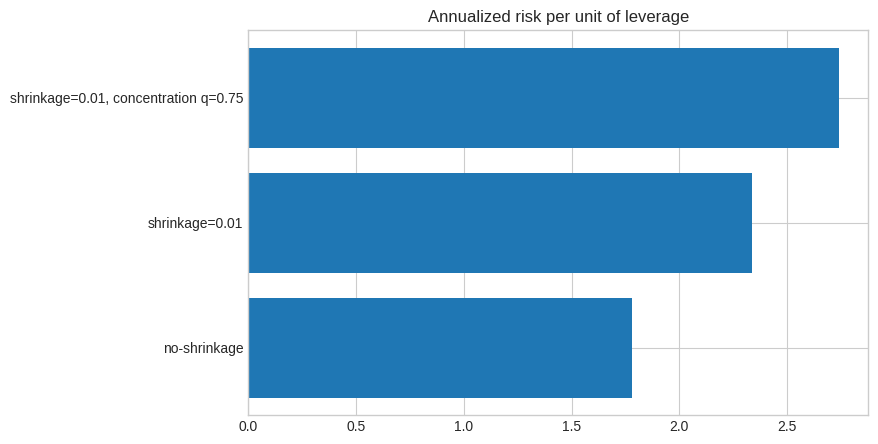

In [25]:
bar(
    pd.Series({k: risk_per_unit_of_leverage(v, ret) for k, v in hs.items()}),
    horizontal=True,
    title="Annualized risk per unit of leverage",
)

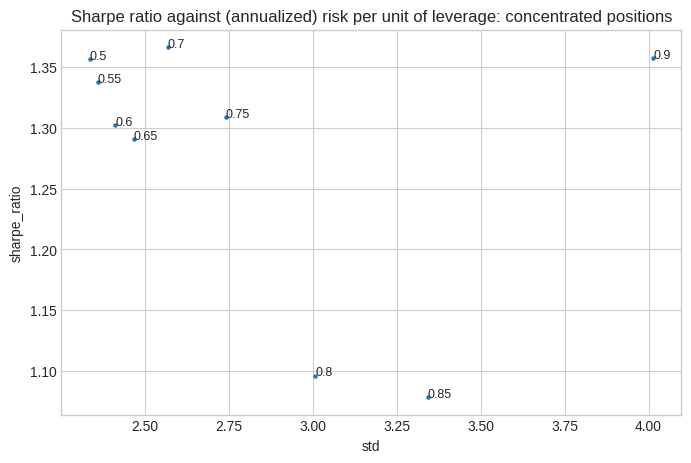

In [26]:
df = pd.DataFrame.from_dict(
    {
        q: m_.h_.pipe(apply_quantile_filter, q=q).pipe(
            risk_per_unit_of_leverage, ret=ret, return_sharpe_ratio=True
        )
        for q in np.arange(0.5, 0.95, 0.05)
    },
    orient="index",
)


fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.scatter(df.iloc[:, 0], df.iloc[:, 1], s=5, c="tab:blue")
ax.set_xlabel(df.columns[0])
ax.set_ylabel(df.columns[1])
ax.set_title(
    "Sharpe ratio against (annualized) risk per unit of leverage: concentrated positions"
)
for i, txt in enumerate(df.index):
    ax.text(df.iloc[i, 0], df.iloc[i, 1], round(txt, 3), fontsize=9)

## Concentrating the predictor instead of the positions

Instead of applying the concentration operator on positions, we can also apply on the predictor. The results are similar. 

In [27]:
from sklearn.pipeline import make_pipeline

In [28]:
res = {}
for q in np.arange(0.5, 0.95, 0.05):
    estimator = make_pipeline(Concentrate(q=q), MeanVariance(transform_V=transform_V_))
    m2_ = Backtester(
        estimator, max_train_size=risk_model_window, start_date="2003-05-01"
    ).compute_holdings(features, target)
    res[q] = m2_.h_.pipe(risk_per_unit_of_leverage, ret=ret, return_sharpe_ratio=True)

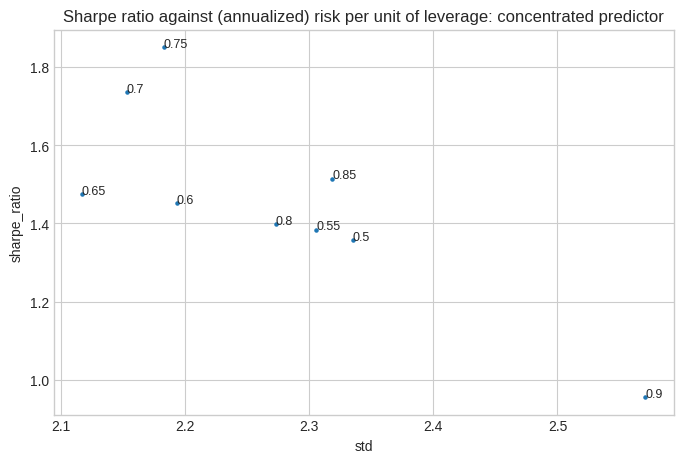

In [29]:
df = pd.DataFrame.from_dict(res, orient="index")

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.scatter(df.iloc[:, 0], df.iloc[:, 1], s=5, c="tab:blue")
ax.set_xlabel(df.columns[0])
ax.set_ylabel(df.columns[1])
ax.set_title(
    "Sharpe ratio against (annualized) risk per unit of leverage: concentrated predictor"
)
for i, txt in enumerate(df.index):
    ax.text(df.iloc[i, 0], df.iloc[i, 1], round(txt, 3), fontsize=9)